# Alexa Skill: Movie ratings and reviews

## Integranes:

- Juan José Urioste Zunino @juanurioste
- Carlos Huerta García @huerta2502
- Alejo Torres Teruel @AlejoTorres2001

## Contenido

En esta entrega se presenta la construcción (build), desarrollo (code) y prueba (test) de una Alexa Skill (aplicación para Amazon Alexa) que obtiene información sobre una película que el usuario indique.

## 1. Build

### Invocation

### Intents

### Samples

### Slots


## 2. Code

### IMDBScrapper.py

Del Scrapper desarrollado para IMDB previamente, se agregó la implementación de una memoria cache con un diccionario que tiene un valor por defecto de `False` para aquellos elementos que no se encuentran, de forma que se guardan en este para incrementar la velocidad de respuesta de la Skill, así como para decrementar el número de peticiones realizadas a IMDB.

In [ ]:
"""
Authors: Juan Jose Urioste (@juanurioste), Carlos Huerta García (@huerta2502)
Date: February 17, 2023

This script gets movie info from IMDB.
"""

import requests
import re
from collections import defaultdict

cache = defaultdict(bool)

def getMovieInfo(movie_title):
    if cache[movie_title] == False:
        cache[movie_title] = requestMovieInfo(movie_title)
    return cache[movie_title]

def requestMovieInfo(title: str):
    """ Gets movie info from IMDB """
    searchHtml = searchMovie(title)
    movieId = getMovieId(searchHtml)
    movieHtml = getMovieContent(movieId)
    movie = getMovie(movieHtml)
    movie['title'] = title
    return movie

def searchMovie(title: str) -> str:
    """ Searches for a movie on IMDB """
    urlstart = 'https://www.imdb.com/find/?q='
    urlend = '&ref_=nv_sr_sm'
    url = urlstart + title + urlend
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36'}
    response = requests.get(url, headers=headers)
    return response.content.decode('utf-8')

def getMovieId(htmlContent: str) -> str:
    """ Gets the movie id from the search results """
    regex = '.*?href="/title/(.*?)/'
    matches = re.search(regex, htmlContent, re.DOTALL)
    return matches.group(1)

def getMovieContent(movieId: str) -> str:
    """ Gets the movie content from the movie id """
    urlstart = 'https://www.imdb.com/title/'
    urlend = '/?ref_=fn_al_tt_1'
    url = urlstart + movieId + urlend
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36'}
    response = requests.get(url, headers=headers)
    return response.content.decode('utf-8')

def getMovie(htmlContent: str):
    """ Gets the movie info from the movie content """
    movie = {}
    movie['duration'] = getMovieDuration(htmlContent)
    movie['rating'] = getMovieRating(htmlContent)
    movie['votes'] = getMovieVotes(htmlContent)
    movie['plot'] = getMoviePlot(htmlContent)
    movie['director'] = getMovieDirector(htmlContent)
    return movie

def getMovieDuration(htmlContent: str) -> str:
    """ Gets the movie duration from the movie content """
    durationRegex = '</li><li role="presentation" class="ipc-inline-list__item">(.*?)</li></ul></div><div';
    durationMatches = re.search(durationRegex, htmlContent, re.DOTALL)
    duration = durationMatches.group(1)
    duration = duration[(len(duration) - 6):len(duration)]
    hours = duration[0:duration.index('h')]
    minutes = duration[(duration.index('h') + 1):duration.index('m')]
    return hours + ' hours and ' + minutes + ' minutes'

def getMovieRating(htmlContent: str) -> str:
    """ Gets the movie rating from the movie content """
    ratingRegex = '<span class="sc-bde20123-1 iZlgcd">(.*?)</span>'
    ratingMatches = re.search(ratingRegex, htmlContent, re.DOTALL)
    return ratingMatches.group(1)

def getMovieVotes(htmlContent: str) -> str:
    """ Gets the movie votes from the movie content """
    votesRegex = '<div class="sc-bde20123-3 bjjENQ">(.*?)</div>'
    votesMatches = re.search(votesRegex, htmlContent, re.DOTALL)
    return votesMatches.group(1)

def getMoviePlot(htmlContent: str) -> str:
    """ Gets the movie plot from the movie content """
    plotRegex = '<span role="presentation" data-testid="plot-l" class="sc-5f699a2-1 cfkOAP">(.*?)</span>'
    plotMatches = re.search(plotRegex, htmlContent, re.DOTALL)
    return plotMatches.group(1)

def getMovieDirector(htmlContent: str) -> str:
    """ Gets the movie director from the movie content """
    directorRegex = '<div class="ipc-metadata-list-item__content-container">(.*?)</div>'
    directorMatches = re.search(directorRegex, htmlContent, re.DOTALL)
    directorsString = re.sub("<.*?>", " ", directorMatches.group(1))
    directorsNames = list(filter(lambda x: x != '', directorsString.split()))
    directors = []
    for i in range(0, len(directorsNames), 2):
        directors.append(directorsNames[i] + ' ' + directorsNames[i + 1])
    return directors


### lambda_function.py

Del código que provee por defecto el asistente al crear una skill, se modificó el mensaje de bienvenida y se definieron las clases `MovieIntentHandler` y `MovieInformationIntentHandler` para la implementación de las preguntas posibles y la construcción de una respuesta para estas. Se utiliza el script del scrapper para obtener la información de las películas obtentiendo el título de la película y la información deseada desde los slots definidos en la construcción con la librería.

Finalmente, se añade al objeto `sb` de la clase `SkillBuilder` un objeto de cada clase definida en su método `add_request_handler` para que se incluida la funcionalidad implementada en la Alexa Skill.

In [ ]:
# -*- coding: utf-8 -*-

# This sample demonstrates handling intents from an Alexa skill using the Alexa Skills Kit SDK for Python.
# Please visit https://alexa.design/cookbook for additional examples on implementing slots, dialog management,
# session persistence, api calls, and more.
# This sample is built using the handler classes approach in skill builder.
import logging

import ask_sdk_core.utils as ask_utils

from ask_sdk_core.skill_builder import SkillBuilder
from ask_sdk_core.dispatch_components import AbstractRequestHandler
from ask_sdk_core.dispatch_components import AbstractExceptionHandler
from ask_sdk_core.handler_input import HandlerInput

from ask_sdk_model import Response

from IMDBScrapper import getMovieInfo

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

class LaunchRequestHandler(AbstractRequestHandler):
    """Handler for Skill Launch."""
    def can_handle(self, handler_input):
        # type: (HandlerInput) -> bool

        return ask_utils.is_request_type("LaunchRequest")(handler_input)

    def handle(self, handler_input):
        # type: (HandlerInput) -> Response
        speak_output = "Welcome to movie ratings and reviews. Ask for any movie that you'd like to know about."

        return (
            handler_input.response_builder
                .speak(speak_output)
                .ask(speak_output)
                .response
        )


class HelloWorldIntentHandler(AbstractRequestHandler):
    """Handler for Hello World Intent."""
    def can_handle(self, handler_input):
        # type: (HandlerInput) -> bool
        return ask_utils.is_intent_name("HelloWorldIntent")(handler_input)

    def handle(self, handler_input):
        # type: (HandlerInput) -> Response
        speak_output = "Hello World!"

        return (
            handler_input.response_builder
                .speak(speak_output)
                # .ask("add a reprompt if you want to keep the session open for the user to respond")
                .response
        )


class HelpIntentHandler(AbstractRequestHandler):
    """Handler for Help Intent."""
    def can_handle(self, handler_input):
        # type: (HandlerInput) -> bool
        return ask_utils.is_intent_name("AMAZON.HelpIntent")(handler_input)

    def handle(self, handler_input):
        # type: (HandlerInput) -> Response
        speak_output = "You can say hello to me! How can I help?"

        return (
            handler_input.response_builder
                .speak(speak_output)
                .ask(speak_output)
                .response
        )


class CancelOrStopIntentHandler(AbstractRequestHandler):
    """Single handler for Cancel and Stop Intent."""
    def can_handle(self, handler_input):
        # type: (HandlerInput) -> bool
        return (ask_utils.is_intent_name("AMAZON.CancelIntent")(handler_input) or
                ask_utils.is_intent_name("AMAZON.StopIntent")(handler_input))

    def handle(self, handler_input):
        # type: (HandlerInput) -> Response
        speak_output = "Goodbye!"

        return (
            handler_input.response_builder
                .speak(speak_output)
                .response
        )

class FallbackIntentHandler(AbstractRequestHandler):
    """Single handler for Fallback Intent."""
    def can_handle(self, handler_input):
        # type: (HandlerInput) -> bool
        return ask_utils.is_intent_name("AMAZON.FallbackIntent")(handler_input)

    def handle(self, handler_input):
        # type: (HandlerInput) -> Response
        logger.info("In FallbackIntentHandler")
        speech = "Hmm, I'm not sure. You can say Hello or Help. What would you like to do?"
        reprompt = "I didn't catch that. What can I help you with?"

        return handler_input.response_builder.speak(speech).ask(reprompt).response

class MovieInformationIntentHandler(AbstractRequestHandler):
    def can_handle(self, handler_input):
        return ask_utils.is_intent_name("MovieInformation")(handler_input)
    
    def build_output(self, result, movie_title, info_key):
        if isinstance(result, list):
            speak_output = movie_title + ' was directed by: '
            directors = []
            for item in result:
                directors.append(item)
            num_directors = len(directors)
            if num_directors == 1:
                speak_output = speak_output + directors[0] + '.'
            elif num_directors == 2:
                speak_output = speak_output + directors[0] + ' and ' + directors[1] + '.'
            else:
                for i in range(num_directors - 1):
                    speak_output = speak_output + directors[i] + ', '
                speak_output = speak_output + 'and ' + directors[-1] + '.'
            return speak_output
        else:
            speak_output = 'The ' + info_key + ' of ' + movie_title
            if info_key == 'votes':
                speak_output = speak_output + ' are: '
            else:
                speak_output = speak_output + ' is: '
            speak_output = speak_output + result + '.'
        return speak_output
        
    def handle(self, handler_input):
        logger.info("In MovieInformation Intent")
        movie_title = ask_utils.get_slot_value(handler_input=handler_input, slot_name="movieName")
        info_key = ask_utils.get_slot_value(handler_input=handler_input, slot_name="movieInfo")
        movie = getMovieInfo(movie_title)
        result = movie[info_key]
        speak_output = self.build_output(result, movie_title, info_key)
        return (
            handler_input.response_builder
            .speak(speak_output)
            .response
        )

class MovieIntentHandler(AbstractRequestHandler):
    def can_handle(self, handler_input):
        return ask_utils.is_intent_name("Movie")(handler_input)
    
    def build_output(self, movie_title, movie):
        speak_output = 'Here is some information about ' + movie_title + ': '
        for key, value in movie.items():
            if isinstance(value, list):
                speak_output = speak_output + ', it was directed by: '
                directors = []
                for item in value:
                    directors.append(item)
                num_directors = len(directors)
                if num_directors == 1:
                    speak_output = speak_output + directors[0]
                elif num_directors == 2:
                    speak_output = speak_output + directors[0] + ' and ' + directors[1]
                else:
                    for i in range(num_directors - 1):
                        speak_output = speak_output + directors[i] + ', '
                    speak_output = speak_output + 'and ' + directors[-1]
            else:
                speak_output = speak_output + ', its ' + key
                if key == 'votes':
                    speak_output = speak_output + ' are: '
                else:
                    speak_output = speak_output + ' is: '
                speak_output = speak_output + value
        return speak_output
        
    def handle(self, handler_input):
        logger.info("In MovieInformation Intent")
        movie_title = ask_utils.get_slot_value(handler_input=handler_input, slot_name="movieName")
        movie = getMovieInfo(movie_title)
        speak_output = self.build_output(movie_title, movie)
        return (
            handler_input.response_builder
            .speak(speak_output)
            .response
        )

class SessionEndedRequestHandler(AbstractRequestHandler):
    """Handler for Session End."""
    def can_handle(self, handler_input):
        # type: (HandlerInput) -> bool
        return ask_utils.is_request_type("SessionEndedRequest")(handler_input)

    def handle(self, handler_input):
        # type: (HandlerInput) -> Response

        # Any cleanup logic goes here.

        return handler_input.response_builder.response


class IntentReflectorHandler(AbstractRequestHandler):
    """The intent reflector is used for interaction model testing and debugging.
    It will simply repeat the intent the user said. You can create custom handlers
    for your intents by defining them above, then also adding them to the request
    handler chain below.
    """
    def can_handle(self, handler_input):
        # type: (HandlerInput) -> bool
        return ask_utils.is_request_type("IntentRequest")(handler_input)

    def handle(self, handler_input):
        # type: (HandlerInput) -> Response
        intent_name = ask_utils.get_intent_name(handler_input)
        speak_output = "You just triggered " + intent_name + "."

        return (
            handler_input.response_builder
                .speak(speak_output)
                # .ask("add a reprompt if you want to keep the session open for the user to respond")
                .response
        )


class CatchAllExceptionHandler(AbstractExceptionHandler):
    """Generic error handling to capture any syntax or routing errors. If you receive an error
    stating the request handler chain is not found, you have not implemented a handler for
    the intent being invoked or included it in the skill builder below.
    """
    def can_handle(self, handler_input, exception):
        # type: (HandlerInput, Exception) -> bool
        return True

    def handle(self, handler_input, exception):
        # type: (HandlerInput, Exception) -> Response
        logger.error(exception, exc_info=True)

        speak_output = "Sorry, I had trouble doing what you asked. Please try again."

        return (
            handler_input.response_builder
                .speak(speak_output)
                .ask(speak_output)
                .response
        )

# The SkillBuilder object acts as the entry point for your skill, routing all request and response
# payloads to the handlers above. Make sure any new handlers or interceptors you've
# defined are included below. The order matters - they're processed top to bottom.


sb = SkillBuilder()

sb.add_request_handler(LaunchRequestHandler())
sb.add_request_handler(HelloWorldIntentHandler())
sb.add_request_handler(HelpIntentHandler())
sb.add_request_handler(CancelOrStopIntentHandler())
sb.add_request_handler(FallbackIntentHandler())
sb.add_request_handler(MovieInformationIntentHandler())
sb.add_request_handler(MovieIntentHandler())
sb.add_request_handler(SessionEndedRequestHandler())
sb.add_request_handler(IntentReflectorHandler()) # make sure IntentReflectorHandler is last so it doesn't override your custom intent handlers

sb.add_exception_handler(CatchAllExceptionHandler())

lambda_handler = sb.lambda_handler()


## 3. Test

### Movie

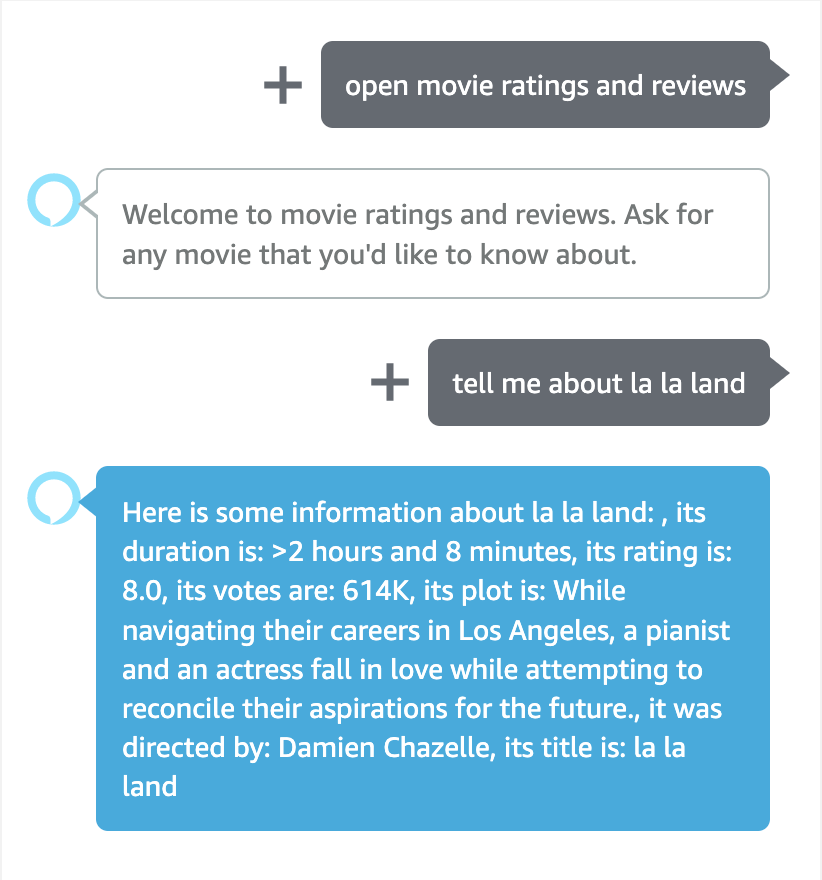

### MovieInformation

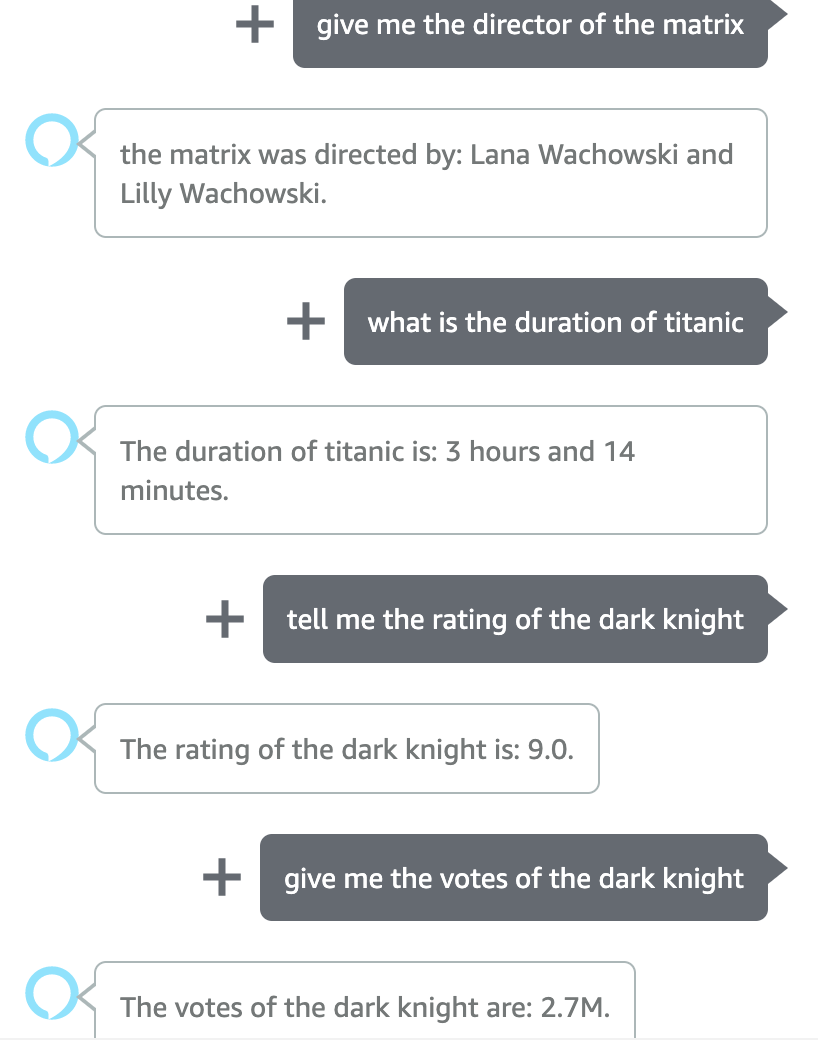
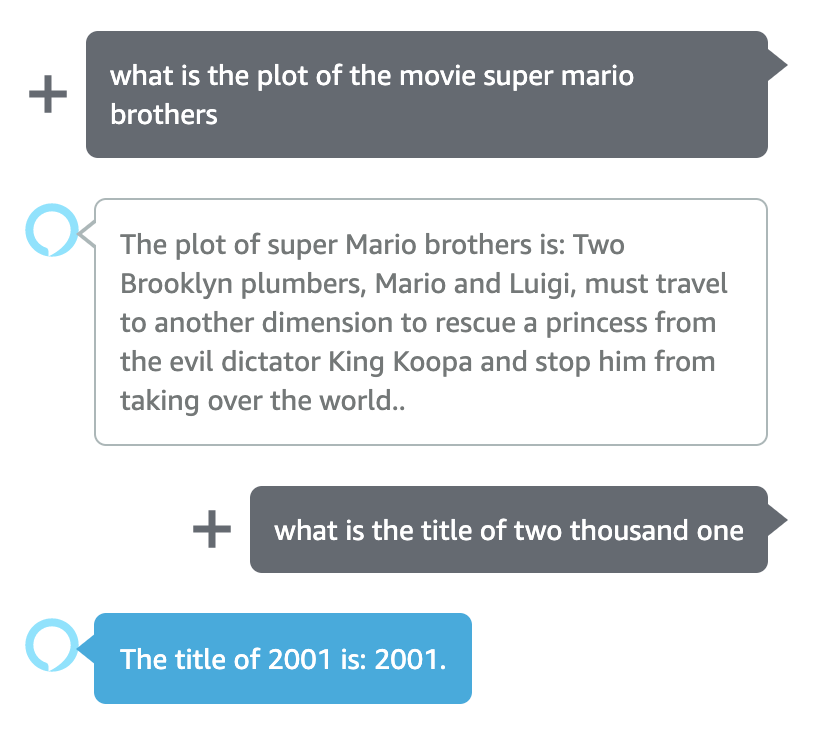